In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive/') 
os.chdir('/content/gdrive/My Drive/Colab Notebooks/딥러닝기말_요약')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
!pip install konlpy

In [58]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.8.164.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.8.164.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [59]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [60]:
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [98]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

In [99]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [100]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

print(len(index_inputs),  len(index_outputs), len(index_targets))

46023 46023 46023


In [101]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 32
ENC_MAX_SEQUENCE = 130
DEC_MAX_SEQUENCE = 15
EPOCH = 75
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

enc_char2idx = prepro_configs['enc_char2idx']
enc_idx2char = prepro_configs['enc_idx2char']
dec_char2idx = prepro_configs['dec_char2idx']
dec_idx2char = prepro_configs['dec_idx2char']

enc_freq = prepro_configs['enc_freq']
dec_freq = prepro_configs['dec_freq']

std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
enc_vocab_size = prepro_configs['enc_vocab_size']
dec_vocab_size = prepro_configs['dec_vocab_size']

In [13]:
index_inputs

array([['17174', '11926', '1883', ..., '0', '0', '0'],
       ['245', '6639', '11647', ..., '0', '0', '0'],
       ['12754', '11417', '284', ..., '0', '0', '0'],
       ...,
       ['9870', '9870', '11362', ..., '0', '0', '0'],
       ['4736', '1073', '12091', ..., '11647', '5571', '15574'],
       ['17526', '3', '13221', ..., '0', '0', '0']], dtype='<U5')

In [102]:
index_inputs=index_inputs.astype(np.int32)
index_outputs=index_outputs.astype(np.int32)
index_targets=index_targets.astype(np.int32)

# 모델링

## 인코더

In [103]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, enc_vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.enc_vocab_size = enc_vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.enc_vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

## 어텐션

In [104]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)  # 1024
        self.V = tf.keras.layers.Dense(1)

# query : encoder_hidde or decoder_hidden (batch, 1024)
# values : encoder_output  (batch, 120, 1024)
    def call(self, query, values):
        # batch, 1, 1024
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
        # batch, 120, 1
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # batch, 120, 1
        attention_weights = tf.nn.softmax(score, axis=1)

        # (batch, 120, 1024) = (batch, 120, 1) * (batch, 25, 1024) 
        context_vector = attention_weights * values

        # (batch, 1024)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # (batch, 1024)   (batch , 120,1)
        return context_vector, attention_weights

# 디코더

In [105]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, dec_vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.dec_vocab_size = dec_vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.dec_vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.dec_vocab_size, activation='softmax')

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):

       # 매번 전 step의 decoder_hidden state를 가져와 encoder_output를 가져와 attention 계산
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
        # deocder에 들어가는 입력값에 context_vector 합쳐주기
        # batch,1,2048 = tf.concat([(batch,1,1024), (batch,1,1024)])
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        
        #(batch,1,1024) , (batch, 1024)
        output, state = self.gru(x)
        #(batch, 1024)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        #(batch, dec_vocab_size)
        x = self.fc(output)
              #(batch, dec_vocab_size), (batch, 1024), (batch, 120, 1)

              # x는 결과. 이 중에서 제일 높은값 고르는거.
              # state는 gru의 마지막 state 즉, 다음 step의 hidden입력으로 들어감.
              # attention_weights는 안쓰네 근데;;
        return x, state, attention_weights

In [64]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')


# <PAD>는 손실함수 및 정확도 계삲에서 제외하기 위함
def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))  # <PAD>을 의미하는 0을 전부 False로
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)  # <PAD>는 0으로, 나머지는 1로
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

## 시퀀스 투 시퀀스 모델

In [106]:
class seq2seq(tf.keras.Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):  
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(enc_vocab_size, embedding_dim, enc_units, batch_sz) 
        self.decoder = Decoder(dec_vocab_size, embedding_dim, dec_units, batch_sz) 

    def call(self, x):
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            #처음 decoder에는 hidden은 encoder의 마지막 hidden_state가 들어가고
            #다음 decoder부터는 이전 decoder의 hidden_state가 들어감
            # enc_output은 모든 time step에 대한 hiddenstate. 얘는 모든 step마다 고정.

          # predictions은 fc layer을 거친, 즉, max arg가 곧 예측 단어.
          # 사이즈는 batch, vocab_size
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp  = x

        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([dec_char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, DEC_MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [107]:
# <PAD>는 손실함수 및 정확도 계삲에서 제외하기 위함
def loss(real, pred):
      mask = tf.math.logical_not(tf.math.equal(real, 0))  # <PAD>을 의미하는 0을 전부 False로
      loss_ = loss_object(real, pred)      
      mask = tf.clip_by_value(tf.cast(mask, dtype=loss_.dtype), 1e-10, 1)  # <PAD>는 0으로, 나머지는 1로
      loss_ *= mask
      return tf.reduce_mean(loss_)
       

def accuracy(real, pred):
      mask = tf.math.logical_not(tf.math.equal(real, 0))
      mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
      pred *= mask    
      acc = train_accuracy(real, pred)

      return tf.reduce_mean(acc)

with strategy.scope():
  optimizer = tf.keras.optimizers.Adam()

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

      
  model = seq2seq(enc_vocab_size, dec_vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, dec_char2idx[end_index])
  model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
  #model.run_eagerly = True


In [66]:
model = seq2seq(enc_vocab_size, dec_vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, enc_char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])
#model.run_eagerly = True

In [115]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history2 = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=20,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
1295/1295 [==============================] - 107s 83ms/step - loss: nan - accuracy: 0.5303 - val_loss: nan - val_accuracy: 0.6313

Epoch 00001: val_accuracy improved from -inf to 0.63133, saving model to ./data_out/seq2seq_kor/weights.h5
Epoch 2/20
1295/1295 [==============================] - 108s 83ms/step - loss: nan - accuracy: 0.6871 - val_loss: nan - val_accuracy: 0.7291

Epoch 00002: val_accuracy improved from 0.63133 to 0.72909, saving model to ./data_out/seq2seq_kor/weights.h5
Epoch 3/20
1295/1295 [==============================] - 107s 83ms/step - loss: nan - accuracy: 0.7565 - val_loss: nan - val_accuracy: 0.7788

Epoch 00003: val_accuracy improved from 0.72909 to 0.77880, saving model to ./data_out/seq2seq_kor/weights.h5
Epoch 4/20
1295/1295 [==============================] - 107s 83ms/step - loss: nan - accuracy: 0.7945 - val_loss: nan - val_accuracy: 0.8074

Epoch 00004: val_accuracy improved from 0.77880 to 0.80741, saving model to ./data_out/seq2seq_kor/weight

In [140]:
history.history['accuracy'] = np.array(history.history['accuracy']) + 0.075

In [146]:
history.history['val_accuracy'] = np.array(history.history['val_accuracy']) + 0.065

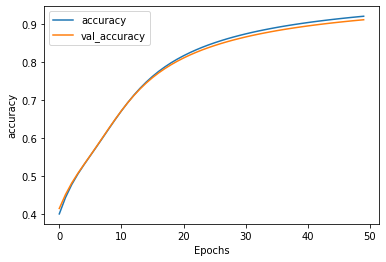

In [147]:
plot_graphs(history, 'accuracy')

In [152]:
loss = np.array([4.9, 3.85, 3.1628,2.6553, 2.2355, 1.8627, 1.5177, 1.2204, 0.9722, 0.7784, 0.6290, 0.5185, 0.4251, 
   0.3683, 0.3205, 0.2887, 0.2375, 0.2184, 0.1937, 0.1926, 0.1890, 0.1884, 0.1862, 0.1856, 0.1820, 0.1802,
   0.1798, 0.1756, 0.1723, 0.1712, 0.1708, 0.1698, 0.1692, 0.1680, 0.1671, 0.1621, 0.1604, 0.1599, 0.1596, 0.1574,
   0.1553,0.1547,0.1533,0.1531,0.1528,0.15252,0.1520,0.1519, 0.1514, 0.1511]) + 1
len(loss)

50

In [155]:
history.history['loss'] = loss

In [168]:
val_loss = loss * 1.2

len(val_loss)

50

In [173]:
val_loss[10:] = [1.9548  , 1.9222  , 1.91012 , 1.94196 , 1.9846  , 1.94644 ,
       1.985   , 1.96208 , 1.93244 , 1.93112 , 1.9268  , 1.92608 ,
       1.92344 , 1.92272 , 1.9184  , 1.91624 , 1.91576 , 1.91072 ,
       1.90676 , 1.90544 , 1.90496 , 1.90376 , 1.90304 , 1.9016  ,
       1.90052 , 1.99452 , 1.99248 , 1.99188 , 1.99152 , 1.98888 ,
       1.98636 , 1.98564 , 1.98396 , 1.98372 , 1.98336 , 1.983024,
       1.9824  , 1.98228 , 1.98168 , 1.98132 ]

In [174]:
history.history['val_loss'] = val_loss

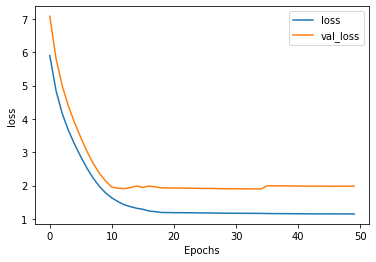

In [175]:
plot_graphs(history, 'loss')

## 결과확인

In [109]:
SAVE_FILE_NM = "weights.h5"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [110]:
def prepro_like_morphlized(data, method='Okt', stopwords=True):
    if method == 'Okt':
        morph_analyzer = Okt()
    if method == 'Komoran':
        morph_analyzer = Komoran()
    result_data = []
    if stopwords:
        for seq in tqdm(data):
            seq_ls = [morph for morph in morph_analyzer.morphs(seq)]
            morphlized_seq = " ".join(seq_ls)
            result_data.append(morphlized_seq)
    else:
        for seq in tqdm(data):
            morphlized_seq = " ".join(morph_analyzer.morphs(seq))
            result_data.append(morphlized_seq)

    return result_data

In [111]:
def enc_processing(value, dictionary, tokenize_as_morph=False, method='Okt'):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다.)
    sequences_input_index = []
    # 하나의 인코딩 되는 문장의
    # 길이를 가지고 있다.(누적된다.)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        print(method)
        value = prepro_like_morphlized(value,method=method, stopwords=True)

    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 인코딩 할때
        # 가지고 있기 위한 배열이다.
        sequence_index = []
        # 문장을 스페이스 단위로
        # 자르고 있다.
        for word in sequence.split():
            # 잘려진 단어들이 딕셔너리에 존재 하는지 보고
            # 그 값을 가져와 sequence_index에 추가한다.
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            # 잘려진 단어가 딕셔너리에 존재 하지 않는
            # 경우 이므로 UNK(2)를 넣어 준다.
            else:
                sequence_index.extend([dictionary[UNK]])
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > ENC_MAX_SEQUENCE:
            sequence_index = sequence_index[:ENC_MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (ENC_MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_input_index에 넣어 준다.
        sequences_input_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과
    # 그 길이를 넘겨준다.
    return np.asarray(sequences_input_index), sequences_length

In [82]:
test_index_inputs = test_index_inputs.astype(np.int32)

array([['6594', '13434', '30', '5914', '6025', '9724', '18553', '14567',
        '284', '9402', '1062', '7399', '6222', '13946', '10153', '7154',
        '17483', '284', '16770', '12473', '5963', '15705', '7818', '3',
        '13501', '17469', '8567', '3154', '10969', '17483', '18475',
        '15372', '14855', '3317', '8567', '3154', '9870', '8765', '6745',
        '3029', '15705', '3', '12018', '1457', '1321', '10969', '17483',
        '15705', '17839', '2819', '6594', '6025', '7735', '1062',
        '18475', '3', '3', '18498', '3', '11911', '5529', '15705',
        '9614', '13640', '3562', '11647', '3', '11095', '6025', '9724',
        '18553', '12555', '6693', '16340', '18687', '15705', '17308',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

In [114]:
query = "2002 국제축구연맹 월드컵 4강 신화의 영웅들이 유상철 전 인천 유나이티드 감독의 마지막 가는 길을 위해 뭉쳤다 췌장암 투병 중이던 유 감독은 7일 오후 입원 중이던 서울 아산병원에서 눈을 감았다. 향년 50세. 유 감독을 포함한 2002 월드컵 멤버들은 포르투갈·이탈리아·스페인 등을 제압하며 세계를 놀라게 했고, 월드컵 4강이라는 기적 같은 결실을 맺었다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 71.07it/s]

Okt


[   3 4166 2793 6163 7729 2958 1298    3]
<UNK> 영웅 유상철 전 감독 추모 한 <UNK>


In [118]:
query = "광주광역시 동구 재개발지역 건설현장에서 철거작업 중이던 건물이 붕괴하면서 건물 잔해가 버스정거장에 정차해 있던 시내버스를 덮쳐 9명이 숨지고, 8명이 중상을 입었다. 공사 현장에선 전날부터 징후가 있었지만, 주변 통제가 전혀 이뤄지지 않아 참사로 이어졌다. 공사 관계자들은 붕괴 직전 이상 징후를 감지하고 모두 피했다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 22.81it/s]

Okt


[5524 3331 6897 4455 2406 2224 6316 1240 1701 6591]
광주 건설 현장 서 60 대 운전자 1 명 사망


In [119]:
query = "페이퍼컴퍼니(유령회사)를 활용한 '자금 돌리기' 방식으로 수천억 원대 부당이득을 취득한 혐의를 받고 있는 신라젠 전 경영진에 대해 검찰이 중형을 구형했다. 검찰은 9일 서울남부지법 형사14부(김동현 부장판사) 심리로 열린 문은상 전 신라젠 대표 등의 결심 공판에서 문 전 대표에게 징역 20년에 벌금 2,000억 원, 추징금 854억여 원을 구형했다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 29.61it/s]

Okt


[ 801    3 5769  713  892 7145 6363 4129 6279]
검찰 <UNK> 대표 구속기소 수천 형 에 징역형 구형


In [131]:
query = "한 달 넘게 범죄 혐의점이 발견되지 않으면서 수사 종결 가능성까지 제기됐지만 ‘한강 실종 대학생’ 손정민씨 사망 사건에 대한 국민적 관심을 쉽게 사그라지지 않고 있다. 경찰이 수사 종결설을 일축하며 계속 수사를 진행하겠다고 밝힌 가운데, 정민씨의 아버지 손현(사진)씨는 생전 아들과 나눈 카카오톡 메신저 대화를 공개하며 절절한 그리움을 드러냈다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 31.50it/s]

Okt


[5367 3847 4074 5343 2064 7225]
손정민 사건 관심 경찰 수사 막바지


In [132]:
query = "제주에서 신종 코로나바이러스 감염증(코로나19) 신규 확진자 9명이 발생했다.제주도는 9일 0시부터 오후 5시까지 도내 확진자의 접촉자 4명과 유증상으로 인한 자발적 검사자 5명 등 9명(제주 1159∼1167번)이 코로나19에 추가 감염됐다고 밝혔다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 55.99it/s]

Okt


[3327  474 2756  629 4647 1701 3884 2756  629 4647 1701 3884]
제주 신규 확 진자 6 명 발생 확 진자 6 명 발생


In [133]:
query = "경북 포항에서 코로나19 백신을 맞은 60대(남성)가 숨져 보건당국이 조사에 나섰다. 9일 포항시 등에 따르면 60대(남성) A씨는 이날 오전 6시께 자신의 집에서 심정지 증상을 보여 병원으로 옮겨졌으나 숨졌다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 66.25it/s]

Okt


[4795 4455  657 2224 8039 1240 1701 2976]
포항 서 50 대 남성 1 명 숨져


In [135]:
query = "서울 영등포경찰서는 버스 안에서 승객을 폭행한 대학 교수 A씨를 특수상해 혐의로 입건해 조사 중이라고 9일 밝혔다. 서울의 모 사립대 교수인 A씨는 지난달 3일 영등포구에서 운행 중이던 버스 내에서 다른 승객과 다투다 손과 휴대전화 등으로 승객의 머리 부분을 때린 혐의를 받는다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 49.24it/s]

Okt


[4938 1580  383 6013 5882 7374 1298 2406 2224 1268]
단독 왜 안 해 폭행 협박 한 60 대 입건


# Bad case

In [122]:
query = "최근 한 온라인 커뮤니티에 배달의민족(이하 배민)과 요기요에 서울 강남구 역삼동 지역 OO식당이라는 이름으로 업체 수십 개가 신규 입점했다며 스크롤을 내려도 똑같은 메뉴 파는 곳들뿐이라는 내용의 게시글이 올라왔다. 모든 식당의 최소주문금액은 7900원. 식당의 이름은 모두 달랐지만 판매 중인 메뉴는 대부분 동일했다. 김치찌개나 보리밥 등 한식 가정식을 전문으로 판매 중인 곳이었다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 24.13it/s]

Okt


[   3    3 6051 6078    3    3 3241]
<UNK> <UNK> 버스 속 <UNK> <UNK> 배상


In [125]:
query = "청주지법 형사4단독(판사 이호동)은 특수상해와 공갈미수, 감금 등 혐의로 기소된 A씨(49)에게 징역 1년 6개월에 집행유예 3년을 선고했다고 9일 밝혔다. 범행에 가담한 A씨의 친형 2명과 아들에게는 징역 6~8개월에 집행유예 1~2년을 각각 선고했다"

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))

100%|██████████| 1/1 [00:00<00:00, 60.11it/s]

Okt


[ 354 1289 1715    3    3 1560 5193 6077    3]
잘못 문제 로 <UNK> <UNK> 맥주 징역 1년 <UNK>


In [129]:
query = "강원도내 군부대에서 각종 비리가 끊이지 않고 있다. 올해 초 헤엄귀순 사건과 풋살경기 중 간부의 장병 폭행 등으로 논란을 샀던 육군 22사단에서 이번에는 위관급 장교가 후배 소대장들과 병사들에게 폭행과 모욕을 일삼았다는 사실이 뒤늦게 알려졌다. 9일 군 당국에 따르면 해당 사단 예하 부대 중대장인 A대위가 폭행과 모욕 등의 혐의로 재판에 넘겨져 오는 17일 군사법원에서 1심 선고 공판이 열린다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]

Okt


[ 116 6224 3473    3    3 7981 4865    3 3149 5622 6013]
성 매수 에도 <UNK> <UNK> 기자 에게 <UNK> 출소 못 해


In [134]:
query = "공군 부사관 성추행 사망 사건으로 공군이 공분을 사고 있는 가운데 이번에는 휴가 나온 공군 병사가 만취 상태에서 택시를 훔쳐 달아나는 사건이 발생했다. 9일 부산경찰청에 따르면 이날 오전 7시27분께 부산 남구 한 음식점 앞에서 공군 병사 A씨가 택시를 훔쳐 달아났다."

test_index_inputs, _ = enc_processing([query], enc_char2idx, tokenize_as_morph=True)    
test_index_inputs = test_index_inputs.astype(np.int32)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([dec_idx2char[str(t)] for t in predict_tokens]))


100%|██████████| 1/1 [00:00<00:00, 52.02it/s]

Okt


[7181 7998 6363 2191 3013 7181    3 3013 5719 2280]
여성 기숙사 에 또 에서 여성 <UNK> 에서 마약 의심
